In [1]:
import torch, os, cv2
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU') if str(device) == "cuda:0" else print('GPU not Detected - CPU Selected')
print(f"GPUs Count: {torch.cuda.device_count()}")

GPU
GPUs Count: 1


In [2]:
def harris_detector(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_f = np.float32(gray_img)
    #harris = cv2.cornerHarris(gray_f, 2, 3, 0.04)   # Default Settings
    harris = cv2.cornerHarris(gray_f, 3, 5, 0.001)   # Extremely Low Settings
    
    harris = cv2.dilate(harris, None)
    #keypoints = np.argwhere(harris > 0.04 * harris.max())  # Default Settings
    keypoints = np.argwhere(harris > 0.001* harris.max())   # Extremely Low Settings
    
    return [cv2.KeyPoint(float(x[1]), float(x[0]), 3) for x in keypoints]

def shi_tomasi_detector(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray_img, maxCorners=1000000, qualityLevel=0.000001, minDistance=1, mask=None, useHarrisDetector=True, k=0.001)   # Default Settings
    #corners = cv2.goodFeaturesToTrack(gray_img, maxCorners=1000000, qualityLevel=0.01, minDistance=1, mask=None, useHarrisDetector=True, k=0.04)       # Extremely Low Settings
    corners = np.intp(corners)
    return [cv2.KeyPoint(float(x), float(y), 3) for [[x, y]] in corners]


#### **Select IMAGE_PAIR**

In [3]:
########################################### Select Image Pair

IMAGE_PAIR = "WALL"     ## Choices:     WALL    GRAF    BIKES    LEUVEN    UBC    DUSTY    SMOKY

########################################################################################################
if IMAGE_PAIR == "WALL":
    input_1 = "./wall/img1.ppm"
    input_2 = "./wall/img6.ppm"
elif IMAGE_PAIR =="GRAF":
    input_1 = "./graf/img1.ppm"
    input_2 = "./graf/img6.ppm"
elif IMAGE_PAIR =="BIKES":
    input_1 = "./bikes/img1.ppm"
    input_2 = "./bikes/img6.ppm"
elif IMAGE_PAIR =="LEUVEN":
    input_1 = "./leuven/img1.ppm"
    input_2 = "./leuven/img6.ppm"
elif IMAGE_PAIR =="UBC":
    input_1 = "./ubc/img1.ppm"
    input_2 = "./ubc/img6.ppm"
elif IMAGE_PAIR =="DUSTY":
    input_1 = "./dusty/img1.bmp"
    input_2 = "./dusty/img2.bmp"
elif IMAGE_PAIR =="SMOKY":
    input_1 = "./smoky/img1.bmp"
    input_2 = "./smoky/img2.bmp"

homo_file_name = "H1to" + input_2[-5] + "p"
homo_file_path = os.path.join(input_1[:-9], homo_file_name)

with open(homo_file_path, "r") as f:
    content = f.read()  # read entire file as string                
    HOMOGRAPHY_MATRIX = np.fromstring(content, sep=" ")
    my_HOMOGRAPHY = HOMOGRAPHY_MATRIX.reshape(-1, 3)
print(my_HOMOGRAPHY)

nndr_threshold = 0.99
my_threshold = 1.0
model_threshold = 0.5

[[ 2.58163100e-01  2.81222035e-02  1.22771933e+02]
 [-9.82734071e-02  9.03428086e-01  8.79736610e+01]
 [-4.09687068e-04  8.67484265e-07  1.00000000e+00]]


### **Select Keypoint Detector**

In [4]:
########################################### Select Detector and Descriptor

KEYPOINT_DETECTOR = "SIFT"     ## Choices:     SIFT    ORB    BRISK    FAST    AGAST

THRESHOLD_SETTINGS = "LOW"     ## Choices:     DEFAULT      LOW 

FEATURE_DESCRIPTOR = "SIFT"    ## Choices:     SIFT    ORB    BRISK

############################################# KEYPOINT DETECTOR #######################################################

if KEYPOINT_DETECTOR == "SIFT":
    if THRESHOLD_SETTINGS == "LOW":
        detector = cv2.SIFT_create(nfeatures=0, nOctaveLayers=4, contrastThreshold=1e-9, edgeThreshold=100, sigma=0.7)
    else:
        detector = cv2.SIFT_create()

elif KEYPOINT_DETECTOR == "ORB":
    if THRESHOLD_SETTINGS == "LOW":
        detector = cv2.ORB_create(nfeatures=1000000, fastThreshold=1)
    else:
        detector = cv2.ORB_create()
        
elif KEYPOINT_DETECTOR == "BRISK":
    if THRESHOLD_SETTINGS == "LOW":
        detector = cv2.BRISK_create(thresh=1, octaves=4)
    else:
        detector = cv2.BRISK_create()
        
elif KEYPOINT_DETECTOR == "FAST":
    if THRESHOLD_SETTINGS == "LOW":
        detector = cv2.FastFeatureDetector_create(threshold=1, nonmaxSuppression=False)
    else:
        detector = cv2.FastFeatureDetector_create()

elif KEYPOINT_DETECTOR == "AGAST":
    if THRESHOLD_SETTINGS == "LOW":
        detector = cv2.AgastFeatureDetector_create(threshold=1, nonmaxSuppression=False, type=cv2.AGAST_FEATURE_DETECTOR_AGAST_7_12D)
    else:
        detector = cv2.AgastFeatureDetector_create()

############################################# KEYPOINT DESCRIPTOR #######################################################

if FEATURE_DESCRIPTOR == "SIFT":
    descriptor = cv2.SIFT_create()
    descriptor_type = 'string_based'
elif FEATURE_DESCRIPTOR == "ORB":
    descriptor = cv2.ORB_create()
    descriptor_type = 'binary'
elif FEATURE_DESCRIPTOR == "BRISK":
    descriptor = cv2.BRISK_create()
    descriptor_type = 'binary'

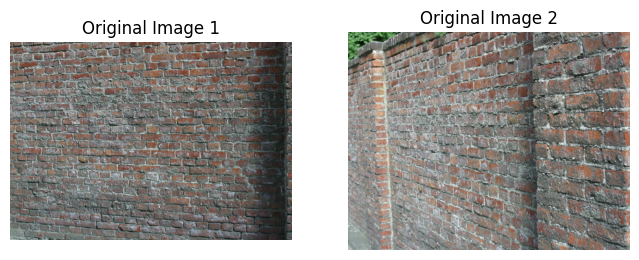

Detected 184084 and 118628 keypoints in the two images respectively.


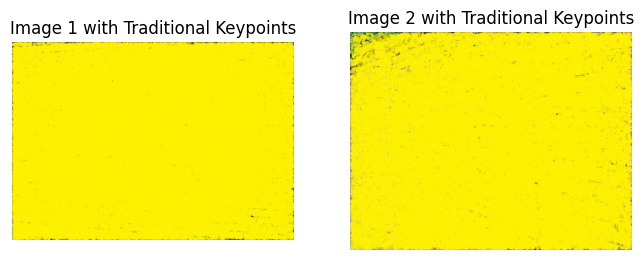

All NNDR Matches (163510 matches)
Correct Matches (52 Correspondences)


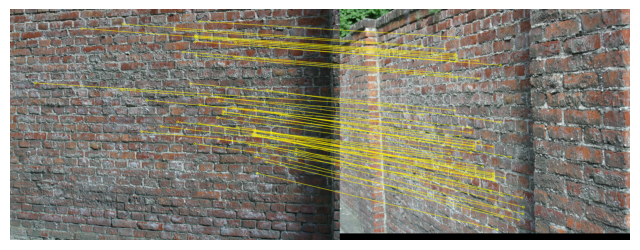

In [5]:
orig_img1 = cv2.imread(input_1)
orig_img2 = cv2.imread(input_2)
img1, img2 = orig_img1, orig_img2

img1_rgb = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2RGB)   # Convert BGR (OpenCV default) to RGB for displaying correctly with matplotlib
img2_rgb = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Original Image 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Original Image 2")
plt.axis('off')
plt.show()

kp1 = detector.detect(img1, None)
kp2 = detector.detect(img2, None)

#kp1 = harris_detector(img1)         #################### For Harris Corner Detector
#kp2 = harris_detector(img2)         #################### For HHarris Corner Detector

#kp1 = shi_tomasi_detector(img1)     #################### For HShi-Tomasi Corner Detector
#kp2 = shi_tomasi_detector(img2)     #################### For HShi-Tomasi Corner Detector

kp1, des1 = descriptor.compute(img1, kp1)
kp2, des2 = descriptor.compute(img2, kp2)

print(f"Detected {len(kp1)} and {len(kp2)} keypoints in the two images respectively.")

img1_kp = cv2.drawKeypoints(img1, kp1, None, (0,242,255), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2_kp = cv2.drawKeypoints(img2, kp2, None, (0,242,255), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

cv2.imwrite("image1_SIFT_low.png", img1_kp)
cv2.imwrite("image2_SIFT_low.png", img2_kp)

img1_kp_rgb = cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB)
img2_kp_rgb = cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp_rgb)
plt.title("Image 1 with Traditional Keypoints")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2_kp_rgb)
plt.title("Image 2 with Traditional Keypoints")
plt.axis('off')
plt.show()

# FLANN Matcher (KD-Tree for SIFT Descriptors)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
if descriptor_type == 'binary':# FLANN Matcher (for ORB or BRISK Descriptors)
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 15, multi_probe_level = 1)

matcher = cv2.FlannBasedMatcher(index_params, search_params)
matches = matcher.knnMatch(np.asarray(des1,np.float32),np.asarray(des2,np.float32),k=2)

# Nearest Neighbour Distance Ratio (NNDR) Test
good_matches = []
nndr_values = []
eps = 1e-12
for m, n in matches:
    ratio = m.distance / (n.distance + eps) # Adding eps to avoid division by zero
    nndr_values.append(ratio)
    if ratio < nndr_threshold:
        good_matches.append(m)
        
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, matchColor=(0,255,0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(f"All NNDR Matches ({len(good_matches)} matches)")

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

if my_HOMOGRAPHY is None:
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacReprojThreshold=1.0, maxIters=50000)
    #F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)  # Use Fundamental Matrix (Epipolar Geometry) to remove outliers - Works best for wide baseline or non-planar scenes
    mask = mask.ravel().tolist()
    inlier_matches = [m for i, m in enumerate(good_matches) if mask[i]]
else:
    threshold = my_threshold  # Pixels
    inlier_matches = []
    for i in range(len(pts1)):
        pt1_h = np.array([pts1[i,0,0], pts1[i,0,1], 1.0])    # Transform point from image 1 using H
        projected_pt1 = my_HOMOGRAPHY @ pt1_h
        projected_pt1 /= projected_pt1[2]                    # Normalize

        error = np.linalg.norm(projected_pt1[:2] - pts2[i,0])
        if error < threshold:
            inlier_matches.append(good_matches[i])

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, matchColor=(0,242,255), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(f"Correct Matches ({len(inlier_matches)} Correspondences)")
cv2.imwrite("matches_SIFT_low.png", img_matches)

plt.figure(figsize=(8,4))
plt.imshow(img_matches[..., ::-1])
plt.axis('off')
plt.show()

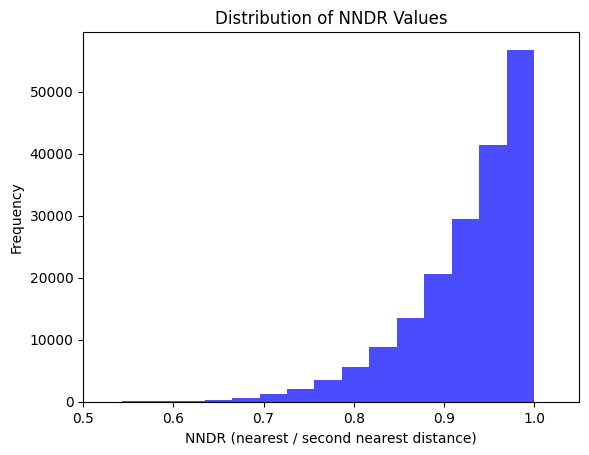

In [6]:
plt.hist(nndr_values, bins=20, color='blue', alpha=0.7)
plt.xlabel("NNDR (nearest / second nearest distance)")
plt.ylabel("Frequency")
plt.title("Distribution of NNDR Values")
plt.xlim([0.5, 1.05])
plt.show()